In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from google.colab import drive

In [10]:
# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Define the path to the Drive directory
drive_path = "/content/drive/MyDrive"

Mounted at /content/drive


In [11]:
# Define the dataset path
dataset_path = os.path.join(drive_path, "dataset_code_language.csv")

# Read the dataset into a DataFrame
data = pd.read_csv(dataset_path)

# Handle missing values and remove duplicates
data.dropna(inplace=True)
data.drop_duplicates(inplace=True)

# Print random examples
print(data.sample(n=15))

                                                    code    language
2076   #! /bin/sh\n# Copyright (C) 2005-2017 Free Sof...        bash
14305  The Senate is set to hold its confirmation hea...   plaintext
3243   @charset "gb2312";\r\nimg{border:0}\r\nbody{pa...         css
12735  PHOENIX (AP) — U.S. transportation officials a...   plaintext
7938   /*! UIkit 3.0.0-rc.8 | http://www.getuikit.com...  javascript
5349   ﻿<html>\n  <head>\n    <meta http-equiv="X-UA-...        html
5618   <!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 T...        html
16383  from treeradix import TreeRadix\nfrom trie imp...      python
8577   'use strict';\n\nmodule.exports.convertToJson ...  javascript
7933   /* See license.txt for terms of usage */\n\n//...  javascript
11136  <?php\n\n/**\n * Pattern or Procedure\n * Chec...         php
2411   #!/bin/sh\n\ntools/gen_wire_io.py h > include/...        bash
9299   jsonp({"cep":"99074200","logradouro":"Rua Dona...  javascript
2883   /*!v3.0.0-beta.3*/.c-avatar

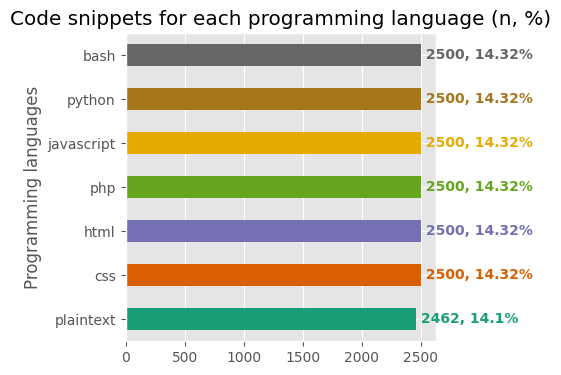

In [12]:
# Define your custom order and reverse it for correct display
order = ['bash', 'python', 'javascript', 'php', 'html', 'css', 'plaintext'][::-1]

# Count the values and sort by the custom order
counts = data["language"].value_counts()
counts = counts.loc[order]

plt.style.use("ggplot")
num_classes = len(counts)
colors = plt.cm.Dark2(np.linspace(0, 1, num_classes))
iter_color = iter(colors)

counts.plot.barh(title="Code snippets for each programming language (n, %)", 
                 ylabel="Programming languages",
                 color=colors,
                 figsize=(4,4))

for i, v in enumerate(counts):
  c = next(iter_color)
  plt.text(v, i,
           " "+str(v)+", "+str(round(v*100/data.shape[0],2))+"%", 
           color=c, 
           va="center", 
           fontweight="bold")

plt.show()

In [13]:
# Train/Test split
X, y = data.code, data.language
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [14]:
# Model params
# This regex pattern is used by the TfidfVectorizer to tokenize the text.
# It matches words, special characters, and spaces/tabs/newlines.
token_pattern = r"""(\b[A-Za-z_]\w*\b|[!\#\$%\&\*\+:\-\./<=>\?@\\\^_\|\~]+|[ \t\(\),;\{\}\[\]`"'])""" 

# Preprocessing function
# This function preprocesses the input data by removing certain patterns.
def preprocess(x):
    """Preprocesses the input data by removing certain patterns."""
    return pd.Series(x).replace(r'\b([A-Za-z])\1+\b', '', regex=True)\
        .replace(r'\b[A-Za-z]\b', '', regex=True)

In [15]:
import multiprocessing

# Get number of available CPUs
# This will be used for parallelizing the computation.
num_cores = multiprocessing.cpu_count()
print(f'Number of available CPUs: {num_cores}')

Number of available CPUs: 40


In [27]:
# Define the steps of the pipeline
# The pipeline sequentially applies a list of transforms and a final estimator.
# Intermediate steps of the pipeline must be 'transforms', that is, they must implement fit and transform methods.
# The final estimator only needs to implement fit.
# The purpose of the pipeline is to assemble several steps that can be cross-validated together while setting different parameters.
transformer = FunctionTransformer(preprocess)
vectorizer = TfidfVectorizer(token_pattern=token_pattern, max_features=3000)
clf = RandomForestClassifier(n_jobs=-1)  # Use all available cores
pipe_RF = Pipeline([
    ('preprocessing', transformer),
    ('vectorizer', vectorizer),
    ('clf', clf)]
)

In [10]:
# Grid of parameters to search over
# GridSearchCV will try all combinations of parameters and find the best ones.
param_grid = {
    'clf__criterion': ['gini', 'entropy'],
    'clf__max_features': ['sqrt', 'log2'],
    'clf__min_samples_split': [2, 3, 4],
    'clf__n_estimators': [100, 200, 300, 400, 500]
}

# Create GridSearchCV instance
# This will perform a exhaustive search over specified parameter values for an estimator.
# cv parameter determines the cross-validation splitting strategy.
grid_search = GridSearchCV(pipe_RF, param_grid, cv=5, verbose=2, n_jobs=-1)  # Use all available cores for GridSearchCV

In [11]:
# Fitting the model
# Here, the GridSearchCV instance is fitted to the training data.
# This will train the model using the best combination of parameters as found by the grid search.
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        FunctionTransformer(func=<function preprocess at 0x7f90476749d0>)),
                                       ('vectorizer',
                                        TfidfVectorizer(max_features=3000,
                                                        token_pattern='(\\b[A-Za-z_]\\w*\\b|[!\\#\\$%\\&\\*\\+:\\-\\./<=>\\?@\\\\\\^_\\|\\~]+|[ '
                                                                      '\\t\\(\\),;\\{\\}\\[\\]`"\'])')),
                                       ('clf',
                                        RandomForestClassifier(n_jobs=-1))]),
             n_jobs=-1,
             param_grid={'clf__criterion': ['gini', 'entropy'],
                         'clf__max_features': ['sqrt', 'log2'],
                         'clf__min_samples_split': [2, 3, 4],
                         'clf__n_estimators': [100, 200, 300, 400, 500]},
             verbose=2)

In [26]:
import pickle

# Define the best_params path
best_params_path = os.path.join(drive_path, "best_params.pkl")

# Save the best parameters
# This will allow us to load these parameters later without needing to perform the grid search again.
with open(best_params_path, 'wb') as f:
    pickle.dump(grid_search.best_params_, f)

In [12]:
# Get the best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print(f'Best parameters: {best_params}')
print(f'Best cross-validation score: {best_score}')

Best parameters: {'clf__criterion': 'gini', 'clf__max_features': 'sqrt', 'clf__min_samples_split': 4, 'clf__n_estimators': 300}
Best cross-validation score: 0.9844166666666666


In [13]:
# Evaluation
print(f'Test set accuracy: {grid_search.score(X_test, y_test)}')

Test set accuracy: 0.9856666666666667


In [14]:
# Classification report
# This report displays the precision, recall, f1-score and support of the model.
y_pred = grid_search.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        bash       0.98      0.99      0.99       509
         css       0.99      0.98      0.99       510
        html       0.97      0.99      0.98       470
  javascript       0.98      0.99      0.98       504
         php       0.99      0.98      0.98       488
      python       0.99      0.99      0.99       519

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000



In [28]:
# Convert predictions to a pandas Series for easier comparison
y_pred_series = pd.Series(y_pred, index=y_test.index)

# Create a DataFrame with text, true labels and predicted labels
df_results = pd.DataFrame({
    'text': X_test,
    'true': y_test,
    'predicted': y_pred_series
})

# Filter for rows where the true label doesn't match the predicted label
misclassified = df_results[df_results.true != df_results.predicted]

# Select five random misclassified examples
random_misclassified = misclassified.sample(n=5)

# Print each of these in a pretty format
for idx, row in random_misclassified.iterrows():
    print(f'Example {idx}:\n\n{row["text"]}\n\nTrue Label: {row["true"]}\nPredicted Label: {row["predicted"]}\n{"-"*50}\n')

Example 11223:

<div class="container">
    <nav class="navbar">
        <div class="navbar-brand">
            <a class="navbar-item" href="/">
                <img src="/images/logo/course.png" alt="选课宝典logo" width="28" height="28">
                <span style="margin-left: .5em; font-size: 18px; font-family: 黑体, 微软雅黑, Arial, Helvetica, sans-serif;">{{ config('app.name') }}</span>
            </a>

            <div class="navbar-burger burger">
                <span></span>
                <span></span>
                <span></span>
            </div>
        </div>

        <div class="navbar-menu">
            <div class="navbar-start">
                <div class="navbar-item has-dropdown is-hoverable">
                    <a class="navbar-link" href="{{ action('Web\CourseController@index') }}">
                        课程
                    </a>
                    <div class="navbar-dropdown">
                        @foreach($categories as $category)
                            

In [15]:
# Making predictions on unseen data
unseen_data = ["""
def get_remote_addr():
    address = flask.request.headers.get('X-Forwarded-For', flask.request.remote_addr)

    try:
        ipaddress.ip_address(address)
    except ValueError:
        return None
    else:
        return address
"""] # This should be a list of strings

# Use the pipeline to make predictions
predictions = grid_search.predict(unseen_data)
print(predictions)

['python']
